## Solving Overfitting

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage.measure import block_reduce
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import sem
from scipy.stats import t

In [3]:
data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=True)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=True)

In [4]:
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])

temp_reduced = block_reduce(temp, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp))
tmax_reduced = block_reduce(temp_max, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_max))
tmin_reduced = block_reduce(temp_min, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_min))
temp_annual_mean = temp_reduced.reshape(-1, 1).flatten()
tmax_annual_mean = tmax_reduced.reshape(-1, 1).flatten()
tmin_annual_mean = tmin_reduced.reshape(-1, 1).flatten()

In [5]:
# Assuming temp, temp_max, and temp_min have shape (num_years, x, y)
num_years_temp, x, y = temp.shape

# Create an array of years to match the reshaped temperature arrays
years_expanded = np.repeat(np.arange(1884, 2023), x * y)

data_dict = {
    'Year': years_expanded,
    'Temperature': temp_annual_mean,
    'Maximum Temperature': tmax_annual_mean,
    'Minimum Temperature': tmin_annual_mean
}
print(len(years_expanded))

1276576


In [6]:
df = pd.DataFrame(data_dict)
df.set_index('Year', inplace=True)
df = df.sort_values(by='Year')
df.dropna(inplace=True)
df['Class'] = df.index.map(lambda year: 'pre_1990' if year < 1990 else 'post_1990')


print(df)

      Temperature  Maximum Temperature  Minimum Temperature      Class
Year                                                                  
1884     6.950380            10.900596             3.138283   pre_1990
1884     6.604088            10.432849             2.901733   pre_1990
1884     5.954602             9.636578             2.450827   pre_1990
1884     6.962700             9.609509             4.750815   pre_1990
1884     6.361767             9.031652             4.420964   pre_1990
...           ...                  ...                  ...        ...
2022     9.321733            13.045972             5.536837  post_1990
2022    10.583754            14.600538             6.504058  post_1990
2022    11.064243            15.244807             6.879631  post_1990
2022    10.834170            14.879905             6.772055  post_1990
2022     8.720055            12.152005             5.342153  post_1990

[237151 rows x 4 columns]


0.7937480673544542
              precision    recall  f1-score   support

   post_1990       0.64      0.31      0.42     17001
    pre_1990       0.81      0.95      0.87     54145

    accuracy                           0.79     71146
   macro avg       0.73      0.63      0.65     71146
weighted avg       0.77      0.79      0.77     71146

Training Set Score: 0.8148
Test Set Score: 0.7937


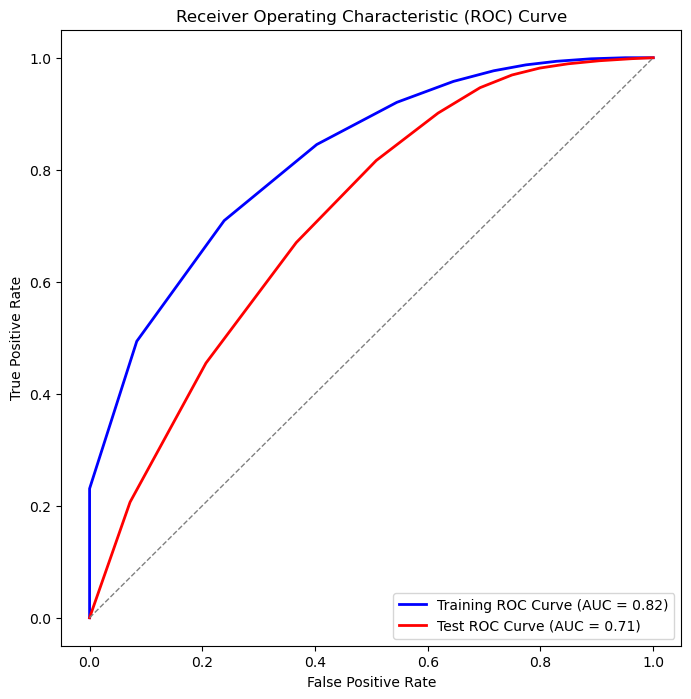

In [18]:
X = df[['Temperature', 'Maximum Temperature', 'Minimum Temperature']].values
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = knn.score(X_test, y_test)
print(accuracy)
print(classification_report(y_test, y_pred))

# Training set score
train_score = knn.score(X_train, y_train)
print(f"Training Set Score: {train_score:.4f}")

# Test set score
test_score = knn.score(X_test, y_test)
print(f"Test Set Score: {test_score:.4f}")

le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

# Get the predicted probabilities for the positive class for both training and test sets
y_train_prob = knn.predict_proba(X_train)[:, 1]
y_test_prob = knn.predict_proba(X_test)[:, 1]

# Compute the ROC curve for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the curve (AUC) for both training and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Investigating AdaBoost

In [4]:
from sklearn.model_selection import train_test_split
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage.measure import block_reduce
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import sem
from scipy.stats import t

data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=True)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=True)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=True)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=True)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=True)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=True)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=True)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=True)

In [5]:
rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

temp_reduced = block_reduce(temp, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp))
tmax_reduced = block_reduce(temp_max, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_max))
tmin_reduced = block_reduce(temp_min, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_min))
rain_reduced = block_reduce(rain, block_size=(12, 1, 1), func=np.mean, cval=np.mean(rain))
hurs_reduced = block_reduce(hurs, block_size=(12, 1, 1), func=np.mean, cval=np.mean(hurs))
sun_reduced = block_reduce(sun, block_size=(12, 1, 1), func=np.mean, cval=np.mean(sun))
frost_reduced = block_reduce(frost, block_size=(12, 1, 1), func=np.mean, cval=np.mean(frost))
psl_reduced = block_reduce(psl, block_size=(12, 1, 1), func=np.mean, cval=np.mean(psl))
wind_reduced = block_reduce(wind, block_size=(12, 1, 1), func=np.mean, cval=np.mean(wind))

min_length = len(wind_reduced)
rain_reduced = rain_reduced[:min_length]
hurs_reduced = hurs_reduced[:min_length]
temp_reduced = temp_reduced[:min_length]
tmax_reduced = tmax_reduced[:min_length]
tmin_reduced = tmin_reduced[:min_length]
sun_reduced = sun_reduced[:min_length]
frost_reduced = frost_reduced[:min_length]
wind_reduced = wind_reduced[:min_length]
psl_reduced = psl_reduced[:min_length]


In [6]:
months_per_year = 12
num_years = temp_max.shape[0] // months_per_year

temp_max_reshaped = temp_max[:num_years * months_per_year].reshape(num_years, months_per_year, temp_max.shape[1], temp_max.shape[2])

temp_max_reshaped = np.max(temp_max_reshaped, axis=1)

tmax_max_annual_mean = temp_max_reshaped[:min_length]

In [7]:
num_years = temp_min.shape[0] // months_per_year

temp_min_reshaped = temp_min[:num_years * months_per_year].reshape(num_years, months_per_year, temp_min.shape[1], temp_min.shape[2])
temp_min_reshaped = np.min(temp_min_reshaped, axis=1)

tmin_min_annual_mean = temp_min_reshaped[:min_length]

In [8]:
months_per_year = 12
num_years = rain.shape[0] // months_per_year

rain_max_reshaped = rain[:num_years * months_per_year].reshape(num_years, months_per_year, rain.shape[1], rain.shape[2])

rain_max_reshaped = np.max(rain_max_reshaped, axis=1)

rain_max_annual_mean = rain_max_reshaped[:min_length]

rain_min_reshaped = rain[:num_years * months_per_year].reshape(num_years, months_per_year, rain.shape[1], rain.shape[2])

rain_min_reshaped = np.min(rain_min_reshaped, axis=1)

rain_min_annual_mean = rain_min_reshaped[:min_length]

In [9]:
months_per_year = 12
num_years = hurs.shape[0] // months_per_year

hurs_max_reshaped = hurs[:num_years * months_per_year].reshape(num_years, months_per_year, hurs.shape[1], hurs.shape[2])

hurs_max_reshaped = np.min(hurs_max_reshaped, axis=1)

hurs_max_annual_mean = hurs_max_reshaped[:min_length]

hurs_min_reshaped = hurs[:num_years * months_per_year].reshape(num_years, months_per_year, hurs.shape[1], hurs.shape[2])

hurs_min_reshaped = np.min(hurs_min_reshaped, axis=1)

hurs_min_annual_mean = hurs_min_reshaped[:min_length]

In [10]:
months_per_year = 12
num_years = sun.shape[0] // months_per_year

sun_max_reshaped = sun[:num_years * months_per_year].reshape(num_years, months_per_year, sun.shape[1], sun.shape[2])

sun_max_reshaped = np.max(sun_max_reshaped, axis=1)

sun_max_annual_mean = sun_max_reshaped[:min_length]

sun_min_reshaped = sun[:num_years * months_per_year].reshape(num_years, months_per_year, sun.shape[1], sun.shape[2])

sun_min_reshaped = np.min(sun_min_reshaped, axis=1)

sun_min_annual_mean = sun_min_reshaped[:min_length]

In [11]:
months_per_year = 12
num_years = frost.shape[0] // months_per_year

frost_max_reshaped = frost[:num_years * months_per_year].reshape(num_years, months_per_year, frost.shape[1], frost.shape[2])

frost_max_reshaped = np.max(frost_max_reshaped, axis=1)

frost_max_annual_mean = frost_max_reshaped[:min_length]

frost_min_reshaped = frost[:num_years * months_per_year].reshape(num_years, months_per_year, frost.shape[1], frost.shape[2])

frost_min_reshaped = np.min(frost_min_reshaped, axis=1)

frost_min_annual_mean = frost_min_reshaped[:min_length]

In [12]:
months_per_year = 12
num_years = psl.shape[0] // months_per_year

psl_max_reshaped = psl[:num_years * months_per_year].reshape(num_years, months_per_year, psl.shape[1], psl.shape[2])

psl_max_reshaped = np.max(psl_max_reshaped, axis=1)

psl_max_annual_mean = psl_max_reshaped[:min_length]

psl_min_reshaped = psl[:num_years * months_per_year].reshape(num_years, months_per_year, psl.shape[1], psl.shape[2])
psl_min_reshaped = np.min(psl_min_reshaped, axis=1)

psl_min_annual_mean = psl_min_reshaped[:min_length]

In [13]:
months_per_year = 12
num_years = wind.shape[0] // months_per_year

wind_max_reshaped = wind[:num_years * months_per_year].reshape(num_years, months_per_year, wind.shape[1], wind.shape[2])

wind_max_reshaped = np.max(wind_max_reshaped, axis=1)

wind_max_annual_mean = wind_max_reshaped[:min_length]

wind_min_reshaped = wind[:num_years * months_per_year].reshape(num_years, months_per_year, wind.shape[1], wind.shape[2])
wind_min_reshaped = np.min(wind_min_reshaped, axis=1)

wind_min_annual_mean = wind_min_reshaped[:min_length]

In [14]:
scaler = MinMaxScaler()

rain = scaler.fit_transform(rain_reduced.reshape(-1, 1)).flatten()
hurs = scaler.fit_transform(hurs_reduced.reshape(-1, 1)).flatten()
temp_annual_mean = scaler.fit_transform(temp_reduced.reshape(-1, 1)).flatten()
tmax_annual_mean = scaler.fit_transform(tmax_reduced.reshape(-1, 1)).flatten()
tmin_annual_mean = scaler.fit_transform(tmin_reduced.reshape(-1, 1)).flatten()
sun = scaler.fit_transform(sun_reduced.reshape(-1, 1)).flatten()
frost = scaler.fit_transform(frost_reduced.reshape(-1, 1)).flatten()
psl = scaler.fit_transform(psl_reduced.reshape(-1, 1)).flatten()
wind = scaler.fit_transform(wind_reduced.reshape(-1, 1)).flatten()
rain_max = scaler.fit_transform(rain_max_annual_mean.reshape(-1, 1)).flatten()
rain_min = scaler.fit_transform(rain_min_annual_mean.reshape(-1, 1)).flatten()
hurs_max = scaler.fit_transform(hurs_max_annual_mean.reshape(-1, 1)).flatten()
hurs_min = scaler.fit_transform(hurs_min_annual_mean.reshape(-1, 1)).flatten()
tmax_max = scaler.fit_transform(tmax_max_annual_mean.reshape(-1, 1)).flatten()
tmin_min = scaler.fit_transform(tmin_min_annual_mean.reshape(-1, 1)).flatten()
sun_max = scaler.fit_transform(sun_max_annual_mean.reshape(-1, 1)).flatten()
sun_min = scaler.fit_transform(sun_min_annual_mean.reshape(-1, 1)).flatten()
frost_max = scaler.fit_transform(frost_max_annual_mean.reshape(-1, 1)).flatten()
frost_min = scaler.fit_transform(frost_min_annual_mean.reshape(-1, 1)).flatten()
psl_max = scaler.fit_transform(psl_max_annual_mean.reshape(-1, 1)).flatten()
psl_min = scaler.fit_transform(psl_min_annual_mean.reshape(-1, 1)).flatten()
wind_max = scaler.fit_transform(wind_max_annual_mean.reshape(-1, 1)).flatten()
wind_min = scaler.fit_transform(wind_min_annual_mean.reshape(-1, 1)).flatten()

In [15]:
# Assuming temp, temp_max, and temp_min have shape (num_years, x, y)
num_years_temp, x, y = temp.shape

# Create an array of years to match the reshaped temperature arrays
years_expanded = np.repeat(np.arange(1969, 2023), x * y)

data_dict = {
    'Year': years_expanded,
    'Temperature': temp_annual_mean,
    'Maximum Temperature': tmax_annual_mean,
    'Maximum Max Temperature': tmax_max,
    'Minimum Temperature': tmin_annual_mean,
    'Minimum Min Temperature': tmin_min,
    'Rainfall': rain,
    'Maximum Rainfall': rain_max,
    'Minimum Rainfall': rain_min,
    'Humidity': hurs,
    'Maximum Humidity': hurs_max,
    'Minimum Humidity': hurs_min,
    'Ground Frost': frost,
    'Maximum Ground Frost': frost_max,
    'Minimum Ground Frost': frost_min,
    'Sunshine': sun,
    'Maximum Sunshine': sun_max,
    'Minimum Sunshine': sun_min,
    'Mean Sea Level Pressure': psl,
    'Maximum Mean Sea Level Pressure': psl_max,
    'Minimum Mean Sea Level Pressure': psl_min,
    'Wind Speed': wind,
    'Maximum Wind Speed': wind_max,
    'Minimum Wind Speed': wind_min
}

df = pd.DataFrame(data_dict)
df.set_index('Year', inplace=True)
df = df.sort_values(by='Year')
df.dropna(inplace=True)
df['Class'] = df.index.map(lambda year: 'pre_1990' if year < 1990 else 'post_1990')


print(df)

      Temperature  Maximum Temperature  Maximum Max Temperature  \
Year                                                              
1969     0.503427             0.530206                 0.508296   
1969     0.468754             0.488834                 0.476249   
1969     0.403725             0.418404                 0.420811   
1969     0.504660             0.416010                 0.383035   
1969     0.444492             0.364899                 0.355628   
...           ...                  ...                      ...   
2022     0.565655             0.539912                 0.532393   
2022     0.687914             0.674667                 0.646078   
2022     0.731090             0.726687                 0.691854   
2022     0.702006             0.685939                 0.667676   
2022     0.518845             0.463227                 0.441207   

      Minimum Temperature  Minimum Min Temperature  Rainfall  \
Year                                                           


In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

X = df[['Temperature', 'Maximum Temperature', 'Maximum Max Temperature', 'Minimum Temperature', 'Minimum Min Temperature', 'Rainfall', 'Maximum Rainfall', 'Minimum Rainfall', 'Humidity', 'Maximum Humidity', 'Minimum Humidity',  'Ground Frost', 'Maximum Ground Frost', 'Minimum Ground Frost', 'Sunshine', 'Maximum Sunshine', 'Minimum Sunshine',  'Mean Sea Level Pressure', 'Maximum Mean Sea Level Pressure', 'Minimum Mean Sea Level Pressure', 'Wind Speed', 'Maximum Wind Speed', 'Minimum Wind Speed']].values
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a weak classifier (Decision Tree in this case)
base_classifier = DecisionTreeClassifier(max_depth=8, random_state=0)

# Instantiate the AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=150, learning_rate=0.01, random_state=0)

# Train the AdaBoost classifier
adaboost_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = adaboost_classifier.predict(X_test)

print('Accuracy on training set: {:3f}'.format(adaboost_classifier.score(X_train, y_train)))
print('Accuracy on test set: {:3f}'.format(adaboost_classifier.score(X_test, y_test)))

Accuracy on training set: 0.964306
Accuracy on test set: 0.949437


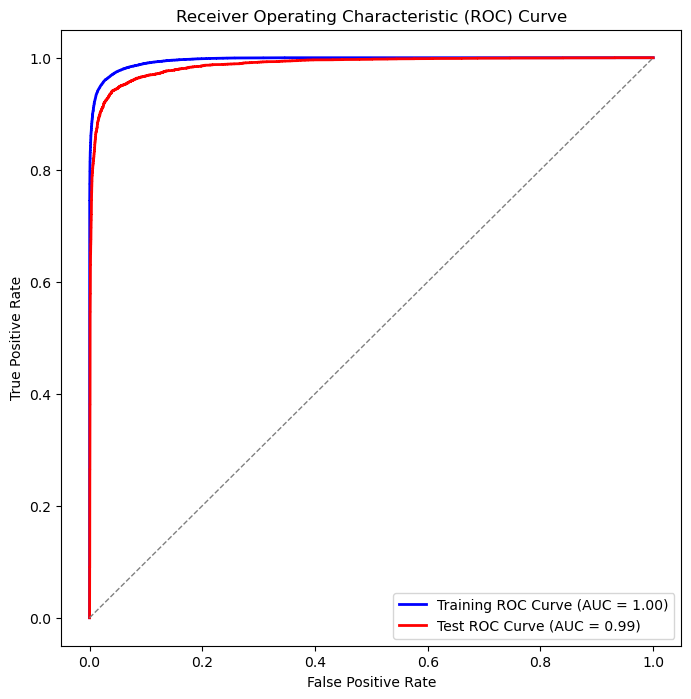

In [22]:
le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

# Get the predicted probabilities for the positive class for both training and test sets
y_train_prob = adaboost_classifier.predict_proba(X_train)[:, 1]
y_test_prob = adaboost_classifier.predict_proba(X_test)[:, 1]

# Compute the ROC curve for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the curve (AUC) for both training and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The mean values of the classes are 0.8053966539756242 0.15563584255421406
The standard deviations of the classes are 0.19572353531711145 0.13245521561585674


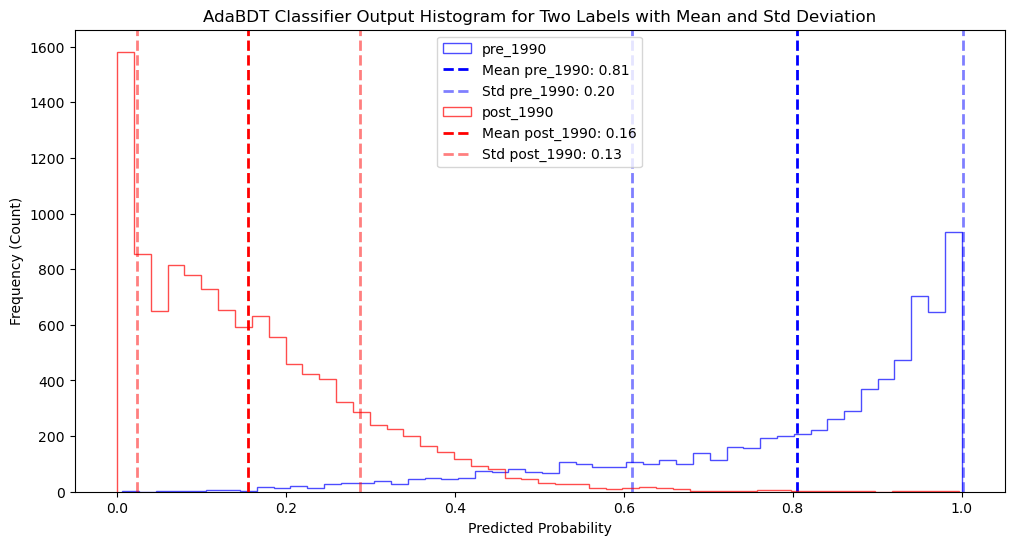

In [23]:
# Get the predicted probabilities for the positive class for the test set
y_test_prob = adaboost_classifier.predict_proba(X_test)[:, 1]

# Create a DataFrame with true labels and predicted probabilities
result_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Probability': y_test_prob
})

label_1 = 'pre_1990'
label_2 = 'post_1990'

# Filter the DataFrame for each label
data_label_1 = result_df[result_df['True_Label'] == label_1]['Predicted_Probability']
data_label_2 = result_df[result_df['True_Label'] == label_2]['Predicted_Probability']

# Calculate mean and standard deviation values
mean_label_1 = np.mean(data_label_1)
std_label_1 = np.std(data_label_1)

mean_label_2 = np.mean(data_label_2)
std_label_2 = np.std(data_label_2)

print('The mean values of the classes are', mean_label_1, mean_label_2)
print('The standard deviations of the classes are', std_label_1, std_label_2)

# Create histograms for each label using matplotlib without density normalization
plt.figure(figsize=(12, 6))

# Histogram for label_1
plt.hist(data_label_1, bins=50, alpha=0.7, label=f'{label_1}', color='blue', histtype='step')
plt.axvline(mean_label_1, color='blue', linestyle='dashed', linewidth=2, label=f'Mean {label_1}: {mean_label_1:.2f}')
plt.axvline(mean_label_1 + std_label_1, color='blue', linestyle='dashed', linewidth=2, label=f'Std {label_1}: {std_label_1:.2f}', alpha=0.5)
plt.axvline(mean_label_1 - std_label_1, color='blue', linestyle='dashed', linewidth=2, alpha=0.5)

# Histogram for label_2
plt.hist(data_label_2, bins=50, alpha=0.7, label=f'{label_2}', color='red', histtype='step')
plt.axvline(mean_label_2, color='red', linestyle='dashed', linewidth=2, label=f'Mean {label_2}: {mean_label_2:.2f}')
plt.axvline(mean_label_2 + std_label_2, color='red', linestyle='dashed', linewidth=2, label=f'Std {label_2}: {std_label_2:.2f}', alpha=0.5)
plt.axvline(mean_label_2 - std_label_2, color='red', linestyle='dashed', linewidth=2, alpha=0.5)

plt.title('AdaBDT Classifier Output Histogram for Two Labels with Mean and Std Deviation')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency (Count)')
plt.legend()
plt.show()

In [24]:
z = (mean_label_1 - mean_label_2) / np.sqrt((std_label_1 **2) + (std_label_2 **2))

print('The Z-score for the nominal AdaBDT classifier with feature engineering is', z)

The Z-score for the nominal AdaBDT classifier with feature engineering is 2.749373952290497


In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

X = df[['Temperature', 'Maximum Temperature', 'Maximum Max Temperature', 'Minimum Temperature', 'Minimum Min Temperature', 'Rainfall', 'Maximum Rainfall', 'Minimum Rainfall', 'Humidity', 'Maximum Humidity', 'Minimum Humidity',  'Ground Frost', 'Maximum Ground Frost', 'Minimum Ground Frost', 'Sunshine', 'Maximum Sunshine', 'Minimum Sunshine',  'Mean Sea Level Pressure', 'Maximum Mean Sea Level Pressure', 'Minimum Mean Sea Level Pressure', 'Wind Speed', 'Maximum Wind Speed', 'Minimum Wind Speed']].values
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a weak classifier (Decision Tree in this case)
base_classifier = DecisionTreeClassifier(max_depth=10, random_state=0)

# Instantiate the AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=150, learning_rate=0.01, random_state=0)

# Train the AdaBoost classifier
adaboost_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = adaboost_classifier.predict(X_test)

print('Accuracy on training set: {:3f}'.format(adaboost_classifier.score(X_train, y_train)))
print('Accuracy on test set: {:3f}'.format(adaboost_classifier.score(X_test, y_test)))

Accuracy on training set: 0.996412
Accuracy on test set: 0.975045


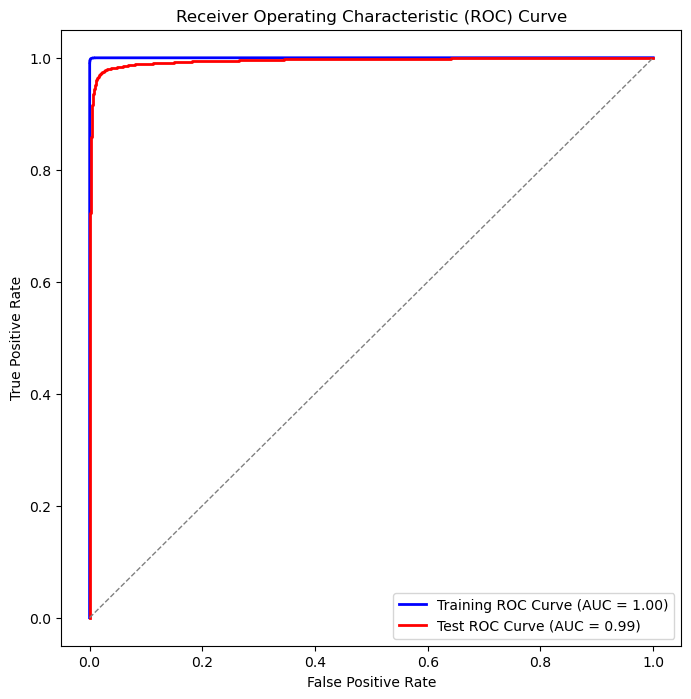

In [26]:
le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

# Get the predicted probabilities for the positive class for both training and test sets
y_train_prob = adaboost_classifier.predict_proba(X_train)[:, 1]
y_test_prob = adaboost_classifier.predict_proba(X_test)[:, 1]

# Compute the ROC curve for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the curve (AUC) for both training and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The mean values of the classes are 0.9142699264780118 0.06274341459827451
The standard deviations of the classes are 0.17008563415550346 0.10387618232135672


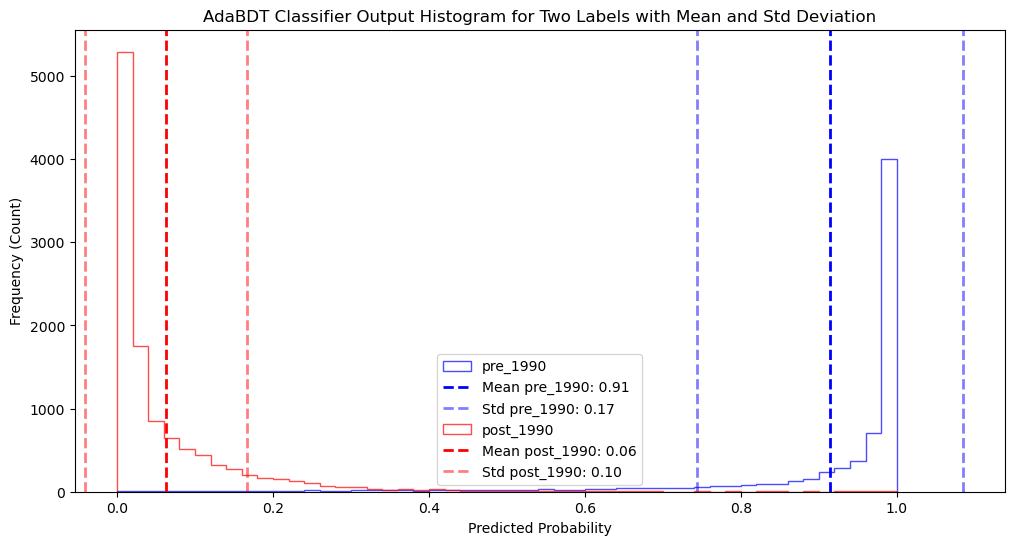

In [27]:
# Get the predicted probabilities for the positive class for the test set
y_test_prob = adaboost_classifier.predict_proba(X_test)[:, 1]

# Create a DataFrame with true labels and predicted probabilities
result_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Probability': y_test_prob
})

label_1 = 'pre_1990'
label_2 = 'post_1990'

# Filter the DataFrame for each label
data_label_1 = result_df[result_df['True_Label'] == label_1]['Predicted_Probability']
data_label_2 = result_df[result_df['True_Label'] == label_2]['Predicted_Probability']

# Calculate mean and standard deviation values
mean_label_1 = np.mean(data_label_1)
std_label_1 = np.std(data_label_1)

mean_label_2 = np.mean(data_label_2)
std_label_2 = np.std(data_label_2)

print('The mean values of the classes are', mean_label_1, mean_label_2)
print('The standard deviations of the classes are', std_label_1, std_label_2)

# Create histograms for each label using matplotlib without density normalization
plt.figure(figsize=(12, 6))

# Histogram for label_1
plt.hist(data_label_1, bins=50, alpha=0.7, label=f'{label_1}', color='blue', histtype='step')
plt.axvline(mean_label_1, color='blue', linestyle='dashed', linewidth=2, label=f'Mean {label_1}: {mean_label_1:.2f}')
plt.axvline(mean_label_1 + std_label_1, color='blue', linestyle='dashed', linewidth=2, label=f'Std {label_1}: {std_label_1:.2f}', alpha=0.5)
plt.axvline(mean_label_1 - std_label_1, color='blue', linestyle='dashed', linewidth=2, alpha=0.5)

# Histogram for label_2
plt.hist(data_label_2, bins=50, alpha=0.7, label=f'{label_2}', color='red', histtype='step')
plt.axvline(mean_label_2, color='red', linestyle='dashed', linewidth=2, label=f'Mean {label_2}: {mean_label_2:.2f}')
plt.axvline(mean_label_2 + std_label_2, color='red', linestyle='dashed', linewidth=2, label=f'Std {label_2}: {std_label_2:.2f}', alpha=0.5)
plt.axvline(mean_label_2 - std_label_2, color='red', linestyle='dashed', linewidth=2, alpha=0.5)

plt.title('AdaBDT Classifier Output Histogram for Two Labels with Mean and Std Deviation')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency (Count)')
plt.legend()
plt.show()

In [28]:
z = (mean_label_1 - mean_label_2) / np.sqrt((std_label_1 **2) + (std_label_2 **2))

print('The Z-score for the nominal AdaBDT classifier with feature engineering is', z)

The Z-score for the nominal AdaBDT classifier with feature engineering is 4.272646087212208
